# Quantifying Entity Novelty
- Exposure (see Carlini et al. 2019)
- Factual Test
- Utilization of a music entities published after the knowledge cut


In [1]:
import pandas as pd
import os

path_exposure = "../data/intermediate/shs100k2_exposure.jsonl"
path_memorizations = "../output/memorization2"

data_wd = pd.read_json(path_exposure, lines=True, orient="records")

data_perfs = pd.read_parquet("../data/raw/shs100k2_yt.parquet")[
    ["set_id", "title", "performer"]].groupby("set_id", as_index=False).agg(list)

__ = []
files = os.listdir(path_memorizations)
for f in files:
    __data = pd.read_json(os.path.join(path_memorizations, f), lines=True, orient="records")
    if "set_id" in __data.columns:
        __data = pd.merge(__data, data_perfs, how="left", on="set_id")
        __data["filename"] = f
        __.append(__data)

data = pd.concat(__)
data["Model"] = data.filename.str.replace(
    "llama3.1-70b.jsonl", "Llama3.1-70B").str.replace(
        "llama3.1-8b.jsonl", "Llama3.1-8B").str.replace(
            "firefunction-v2.jsonl", "FireFunction-v2"
        ).str.replace(
            "mixtral-8x22b.jsonl", "Mixtral-8x22B"
        ).str.replace("gpt-4o-mini.jsonl", "GPT-4o-mini")
           

In [2]:
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import (unicode_normalize, remove_brackets_and_all_content, 
                   remove_bracket_only, replace_linebreaks_tabs)
processing_attrs = ["artist_original", "artist_perf", "composer"]
preprocessor = PerformerStringPreprocessor()


def preprocessing(s: str) -> str:
        s = unicode_normalize(s)
        # remove brackets with one-word content eg "[us]"
        s = remove_brackets_and_all_content(s)
        # remove brackets but keep content, eg. when (feat. Metallica) keep feat. Metallica
        s = remove_bracket_only(s)
        # split performers by defined separators
        l = preprocessor.split_performers(replace_linebreaks_tabs(s))
        # also consider performer names without artists
        l = preprocessor.article_preprocessing(l)
        return ','.join(l)

data.artist_original = data.artist_original.apply(lambda x: preprocessing(x) if type(x) == str else None)
data.artist_perf = data.artist_perf.apply(lambda x: preprocessing(x) if type(x) == str else None)
data.composer = data.composer.apply(lambda x: preprocessing(x) if type(x) == str else None)


In [3]:
def AW1_correct(row):
    if not pd.isna(row.AW1) and not pd.isna(row.artist_original):
        aws = row.AW1.split()
        return any([aw.lower() in [a.lower() for a in row.artist_original.split()] for aw in aws])
    return

def artist_partly_correct(row, answer_col: str):
    if not pd.isna(row[answer_col]) and isinstance(row.performer, list):
        artists = row[answer_col].split()
        if row.artist_original:
            artists += row.artist_original.split()
        if row.composer:
            artists += row.composer.split()
        for artist in artists:
            for performer in row.performer:
                if artist in performer:
                    return True
    else: 
        return None
    return False

def AW2_correct(row):
    if not pd.isna(row.AW3) and not pd.isna(row.composer):
        aws = row.AW3.split()
        return any([aw.lower() in [c.lower() for c in row.composer.split()] for aw in aws])
    return

data["AW1: Correct"] = data.apply(AW1_correct, axis=1)
data["AW1: Related"] = data.apply(lambda x: artist_partly_correct(x, "AW1"), axis=1)

data["AW2: Correct"] = data.apply(AW2_correct, axis=1)
data["AW2: Related"] = data.apply(lambda x: artist_partly_correct(x, "AW2"), axis=1)



In [4]:

id_cols = ['set_id', 'work_id', 'perf_id', 'Model']
aw_cols = [col for col in data.columns if col.startswith('AW') and ":" in col]

data[id_cols + aw_cols]

data_melted = data.melt(id_vars=id_cols, value_vars=aw_cols)

data_melted_pivoted = data_melted.pivot_table(
    index=['set_id', 'work_id', 'perf_id'],
    columns=['Model', 'variable'],
    values='value',
    aggfunc='first'  # 'first' because we assume there is no aggregation needed if values are unique
)
data_melted_pivoted.reset_index().to_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")
data_melted_pivoted



Model                    FireFunction-v2                            \
variable                    AW1: Correct AW1: Related AW2: Correct   
set_id work_id  perf_id                                              
0      4681.0   132979.0           False         True         True   
1      7895.0   7895.0              True         True         True   
2      7896.0   86970.0             True        False         True   
3      12959.0  507152.0           False        False         True   
4      312438.0 51032.0             True         True        False   
...                                  ...          ...          ...   
9992   97193.0  97193.0            False        False        False   
                97194.0            False        False        False   
9993   9750.0   9750.0              True         True        False   
9994   98356.0  98356.0             True        False        False   
9998   9900.0   9900.0             False        False        False   

Model                                  GPT-4o-mini                            \
variable                 AW2: Related AW1: Correct AW1: Related AW2: Correct   
set_id work_id  perf_id                                                        
0      4681.0   132979.0         True        False         True         True   
1      7895.0   7895.0           True        False         True        False   
2      7896.0   86970.0         False        False        False        False   
3      12959.0  507152.0        False        False        False         True   
4      312438.0 51032.0          True         True         True        False   
...                               ...          ...          ...          ...   
9992   97193.0  97193.0         False        False        False        False   
                97194.0         False        False        False        False   
9993   9750.0   9750.0           True         True         True         True   
9994   98356.0  98356.0         False        False        False        False   
9998   9900.0   9900.0           True        False         True        False   

Model                                 Llama3.1-70B                            \
variable                 AW2: Related AW1: Correct AW1: Related AW2: Correct   
set_id work_id  perf_id                                                        
0      4681.0   132979.0         True        False         True         True   
1      7895.0   7895.0           True         True         True         True   
2      7896.0   86970.0         False         True        False         True   
3      12959.0  507152.0         True        False        False         True   
4      312438.0 51032.0          True         True         True        False   
...                               ...          ...          ...          ...   
9992   97193.0  97193.0         False        False         True        False   
                97194.0         False        False         True        False   
9993   9750.0   9750.0           True         True         True        False   
9994   98356.0  98356.0         False         True        False        False   
9998   9900.0   9900.0           True        False        False        False   

Model                                  Llama3.1-8B                            \
variable                 AW2: Related AW1: Correct AW1: Related AW2: Correct   
set_id work_id  perf_id                                                        
0      4681.0   132979.0         True        False         True         True   
1      7895.0   7895.0           True         True         True         True   
2      7896.0   86970.0         False         True        False         True   
3      12959.0  507152.0        False        False         True         True   
4      312438.0 51032.0          True        False         True        False   
...                               ...          ...          ...          ...   
9992   97193.0  97193.0         False        False       

In [5]:
data_melted_pivoted[data_melted_pivoted[("Llama3.1-70B", "AW1: Correct")].isna()]


Empty DataFrame
Columns: [(FireFunction-v2, AW1: Correct), (FireFunction-v2, AW1: Related), (FireFunction-v2, AW2: Correct), (FireFunction-v2, AW2: Related), (GPT-4o-mini, AW1: Correct), (GPT-4o-mini, AW1: Related), (GPT-4o-mini, AW2: Correct), (GPT-4o-mini, AW2: Related), (Llama3.1-70B, AW1: Correct), (Llama3.1-70B, AW1: Related), (Llama3.1-70B, AW2: Correct), (Llama3.1-70B, AW2: Related), (Llama3.1-8B, AW1: Correct), (Llama3.1-8B, AW1: Related), (Llama3.1-8B, AW2: Correct), (Llama3.1-8B, AW2: Related), (Mixtral-8x22B, AW1: Correct), (Mixtral-8x22B, AW1: Related), (Mixtral-8x22B, AW2: Correct), (Mixtral-8x22B, AW2: Related)]
Index: []

# Analysis

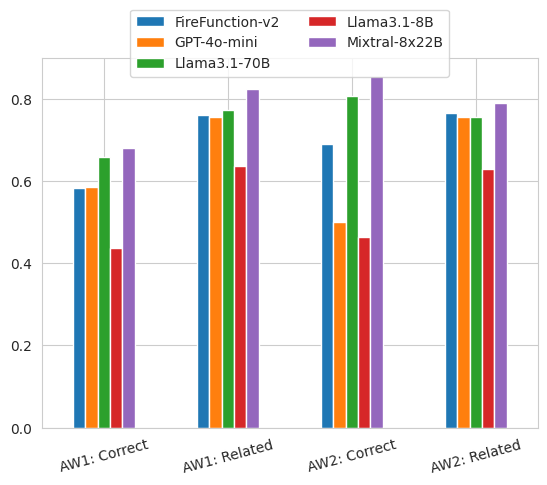

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

__data = data_melted_pivoted.sum().unstack(level=0) 
prob = lambda x: x / data.set_id.nunique()
__data = __data.apply(prob)
__data.plot(kind="bar")

plt.xticks(rotation=15)
plt.xlabel("")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.savefig("../figures/memorization_test.pdf")
plt.show()
